In [1]:
#import below libraries
import awswrangler as wr
import pandas as pd
import boto3
import warnings 
warnings.filterwarnings('ignore')
import configparser

In [2]:
#reading the credentials securely.
credents = configparser.ConfigParser()

In [4]:
#use read_file method
credents.read('C:\Fall 2022 courses\Project\GRA-Data-Engineering-Work\secret.config')

['C:\\Fall 2022 courses\\Project\\GRA-Data-Engineering-Work\\secret.config']

In [5]:
#Reading in the credentials into Python variables. No can see them
aws_key = credents["AWS"]["KEY"]
aws_secret = credents["AWS"]["SECRET"]
region = credents["AWS"]["REGION"]

In [6]:
#Creating the Session
your_session = boto3.Session(aws_access_key_id=aws_key,
                            aws_secret_access_key=aws_secret,
                            region_name=region)

In [7]:
#verifying your session by listing the buckets
your_buckets = wr.s3.list_buckets(boto3_session=your_session)
your_buckets

['walmart-east-2-usama']

In [138]:
 # Creating new S3 bucket

#Create bucket name
bucket_name='walmart-east-2-tracker-new'

#Create Bucket
s3client=your_session.client('s3')
s3client.create_bucket(Bucket=bucket_name)


{'ResponseMetadata': {'RequestId': '7ZCJ6GRN1DS4VWV8',
  'HostId': 'YSxAUuEm/MfTMmjD8tekQeMRpwsaJQ5WiyhM8CHvNS44NoX7nCGCVKN2P/h82sWO+PINyhLce2FUmN6CjkzJn2uBSqtMdtc42SerhYrYjsM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'YSxAUuEm/MfTMmjD8tekQeMRpwsaJQ5WiyhM8CHvNS44NoX7nCGCVKN2P/h82sWO+PINyhLce2FUmN6CjkzJn2uBSqtMdtc42SerhYrYjsM=',
   'x-amz-request-id': '7ZCJ6GRN1DS4VWV8',
   'date': 'Tue, 27 Jun 2023 19:52:51 GMT',
   'location': '/walmart-east-2-tracker-new',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'Location': '/walmart-east-2-tracker-new'}

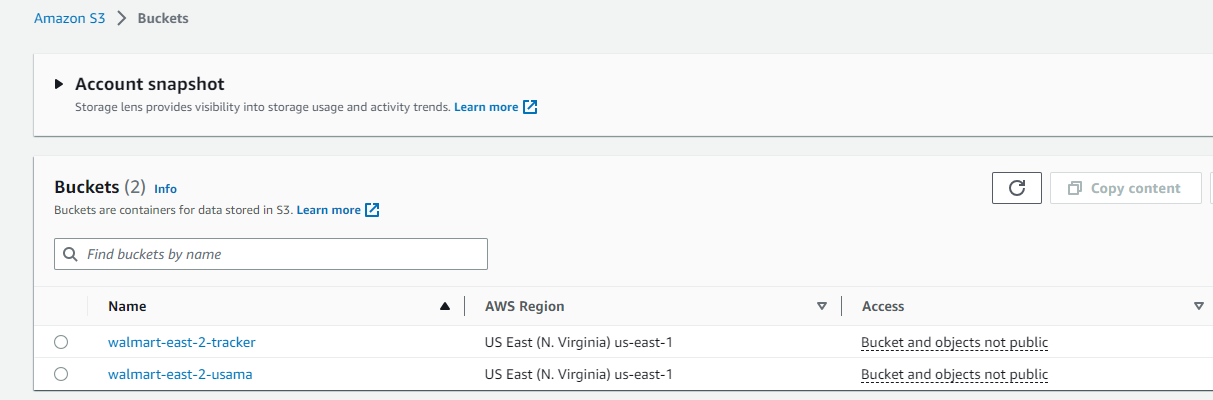

In [113]:
## running Athena queries

## setup Athena 
athena_client = your_session.client('athena')

## Setup the query
DATABASE_NAME = "ccindex"
RESULT_OUTPUT_LOCATION = "s3://walmart-east-2-usama/walmart_laptops_2018/"

def create_database():
    response = athena_client.start_query_execution(
        QueryString=f"create database {DATABASE_NAME}",
        ResultConfiguration={"OutputLocation": RESULT_OUTPUT_LOCATION}
    )

    return response["QueryExecutionId"]

# Create database
create_database()

'c82ec28a-500c-4496-9484-4c6e25ccdcc4'

In [114]:
## Create a DDL file for table in Athena

create_table_query="""
CREATE EXTERNAL TABLE IF NOT EXISTS ccindex (
  url_surtkey                   STRING,
  url                           STRING,
  url_host_name                 STRING,
  url_host_tld                  STRING,
  url_host_2nd_last_part        STRING,
  url_host_3rd_last_part        STRING,
  url_host_4th_last_part        STRING,
  url_host_5th_last_part        STRING,
  url_host_registry_suffix      STRING,
  url_host_registered_domain    STRING,
  url_host_private_suffix       STRING,
  url_host_private_domain       STRING,
  url_protocol                  STRING,
  url_port                      INT,
  url_path                      STRING,
  url_query                     STRING,
  fetch_time                    TIMESTAMP,
  fetch_status                  SMALLINT,
  content_digest                STRING,
  content_mime_type             STRING,
  content_mime_detected         STRING,
  content_charset               STRING,
  content_languages             STRING,
  warc_filename                 STRING,
  warc_record_offset            INT,
  warc_record_length            INT,
  warc_segment                  STRING)
PARTITIONED BY (
  crawl                         STRING,
  subset                        STRING)
STORED AS parquet
LOCATION 's3://commoncrawl/cc-index/table/cc-main/warc/';
"""

#create function to run query

def create_table():
    response = athena_client.start_query_execution(
        QueryString=f"{create_table_query}",
        ResultConfiguration={"OutputLocation": RESULT_OUTPUT_LOCATION}
    )

    return response["QueryExecutionId"]

# Create table
create_table()

'9e43a47e-fad4-4d38-9b95-00edf7940a2d'

In [115]:
# Run a query to to make Athena recognize the data partitions on S3, you have to execute the SQL statement

#create function to run query

query= "MSCK REPAIR TABLE ccindex"
def data_partition_understand():
    response = athena_client.start_query_execution(
        QueryString=f"{query}",
        ResultConfiguration={"OutputLocation": RESULT_OUTPUT_LOCATION}
    )

    return response["QueryExecutionId"]

# Create table
data_partition_understand()

'eb58c309-f3c6-47ee-af97-c0e62dc237a0'

In [116]:
wr.athena.describe_table(database='ccindex',table='ccindex',
                         boto3_session=your_session)

,Column Name,Type,Partition,Comment
0,url_surtkey,string,False,
1,url,string,False,
2,url_host_name,string,False,
3,url_host_tld,string,False,
4,url_host_2nd_last_part,string,False,
5,url_host_3rd_last_part,string,False,
6,url_host_4th_last_part,string,False,
7,url_host_5th_last_part,string,False,
8,url_host_registry_suffix,string,False,
9,url_host_registered_domain,string,False,


A short check whether the blocking of internet connections from and to the Islamic Republic of Iran had an impact on the data of the November 2019 crawl (CC-MAIN-2019-47).

First, extract per-hour page counts for the .ir top-level domain and a couple of reference domains (.mx, .lt, .me, .pt) of similar size to exclude global network or crawler issues. Capture time stamps are in seconds, the Presto date and time functions are used to aggregate the counts by hour.

In [131]:
df=wr.athena.read_sql_query(sql="""
SELECT date_trunc('hour', fetch_time) as capture_time,
       url_host_tld,
       COUNT(*) as count
FROM "ccindex"."ccindex"
WHERE crawl = 'CC-MAIN-2019-47'
  AND subset = 'warc'
  AND contains(ARRAY['ir', 'pt', 'lt', 'me', 'mx'], url_host_tld)
GROUP BY url_host_tld, date_trunc('hour', fetch_time)
ORDER BY date_trunc('hour', fetch_time)
""",
boto3_session=your_session,database='ccindex')

df.head()

,capture_time,url_host_tld,count
0,2019-11-11 19:00:00,mx,15274
1,2019-11-11 19:00:00,lt,20509
2,2019-11-11 19:00:00,pt,16928
3,2019-11-11 19:00:00,me,21923
4,2019-11-11 19:00:00,ir,20540


In [132]:
# Let's inspect the extracted data

df=df.set_index('capture_time')
df = df.to_period(freq='H')
df.head(6)

,url_host_tld,count
capture_time,,
2019-11-11 19:00,mx,15274
2019-11-11 19:00,lt,20509
2019-11-11 19:00,pt,16928
2019-11-11 19:00,me,21923
2019-11-11 19:00,ir,20540
2019-11-11 20:00,ir,32993


<AxesSubplot:xlabel='capture_time'>

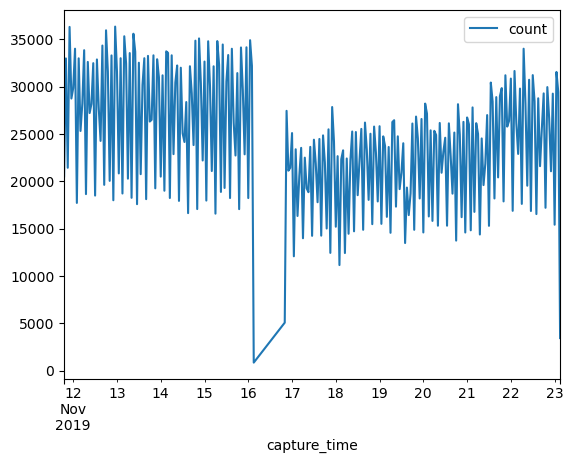

In [133]:
# try a first plot only for the counts of the .ir top-level domain

df[df['url_host_tld'] == 'ir'].plot()

In [ ]:
df_inflation_tracker=wr.athena.read_sql_query(sql="""
CREATE TABLE output_new
WITH ( format='PARQUET',  external_location = 's3://walmart-east-2-tracker-new/processed_data/') AS
SELECT url,
         warc_filename,
         warc_record_offset,
         warc_record_length
FROM "ccindex"."ccindex"
WHERE (crawl = 'CC-MAIN-2018-05' OR crawl = 'CC-MAIN-2018-09' OR crawl = 'CC-MAIN-2018-13' OR crawl = 'CC-MAIN-2018-17' OR crawl = 'CC-MAIN-2018-22' 
       OR crawl = 'CC-MAIN-2018-26' OR crawl = 'CC-MAIN-2018-30' OR crawl = 'CC-MAIN-2018-34' OR crawl = 'CC-MAIN-2018-39' OR crawl = 'CC-MAIN-2018-43'
       OR crawl = 'CC-MAIN-2018-47' OR crawl = 'CC-MAIN-2018-51')
        AND position('walmart.com' IN url) != 0
        AND position('laptop' IN url) != 0
""",
boto3_session=your_session,database='ccindex')

df_inflation_tracker.head()

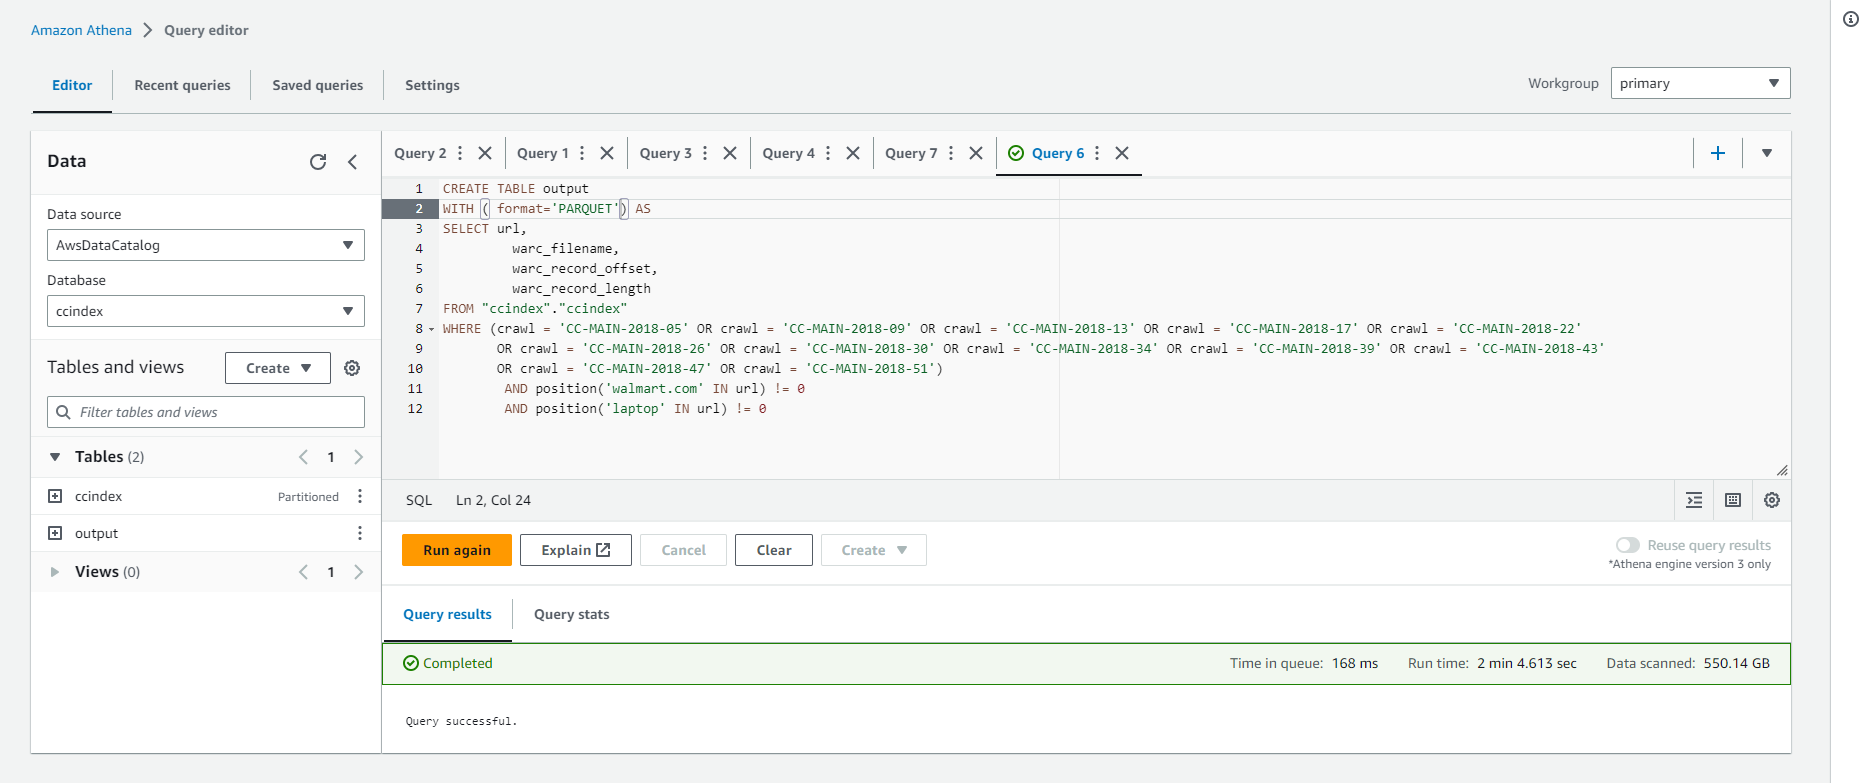